In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot
from Scaling import time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정

Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


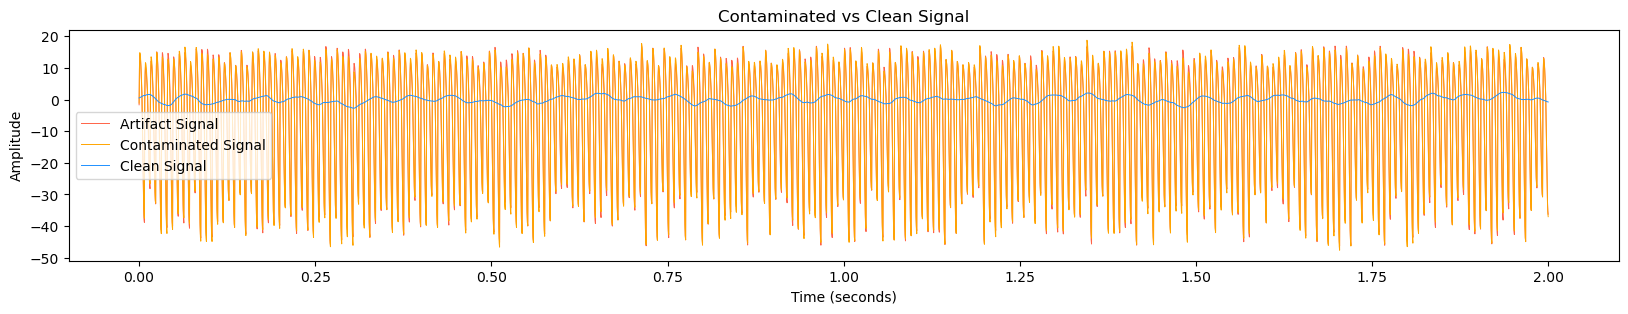

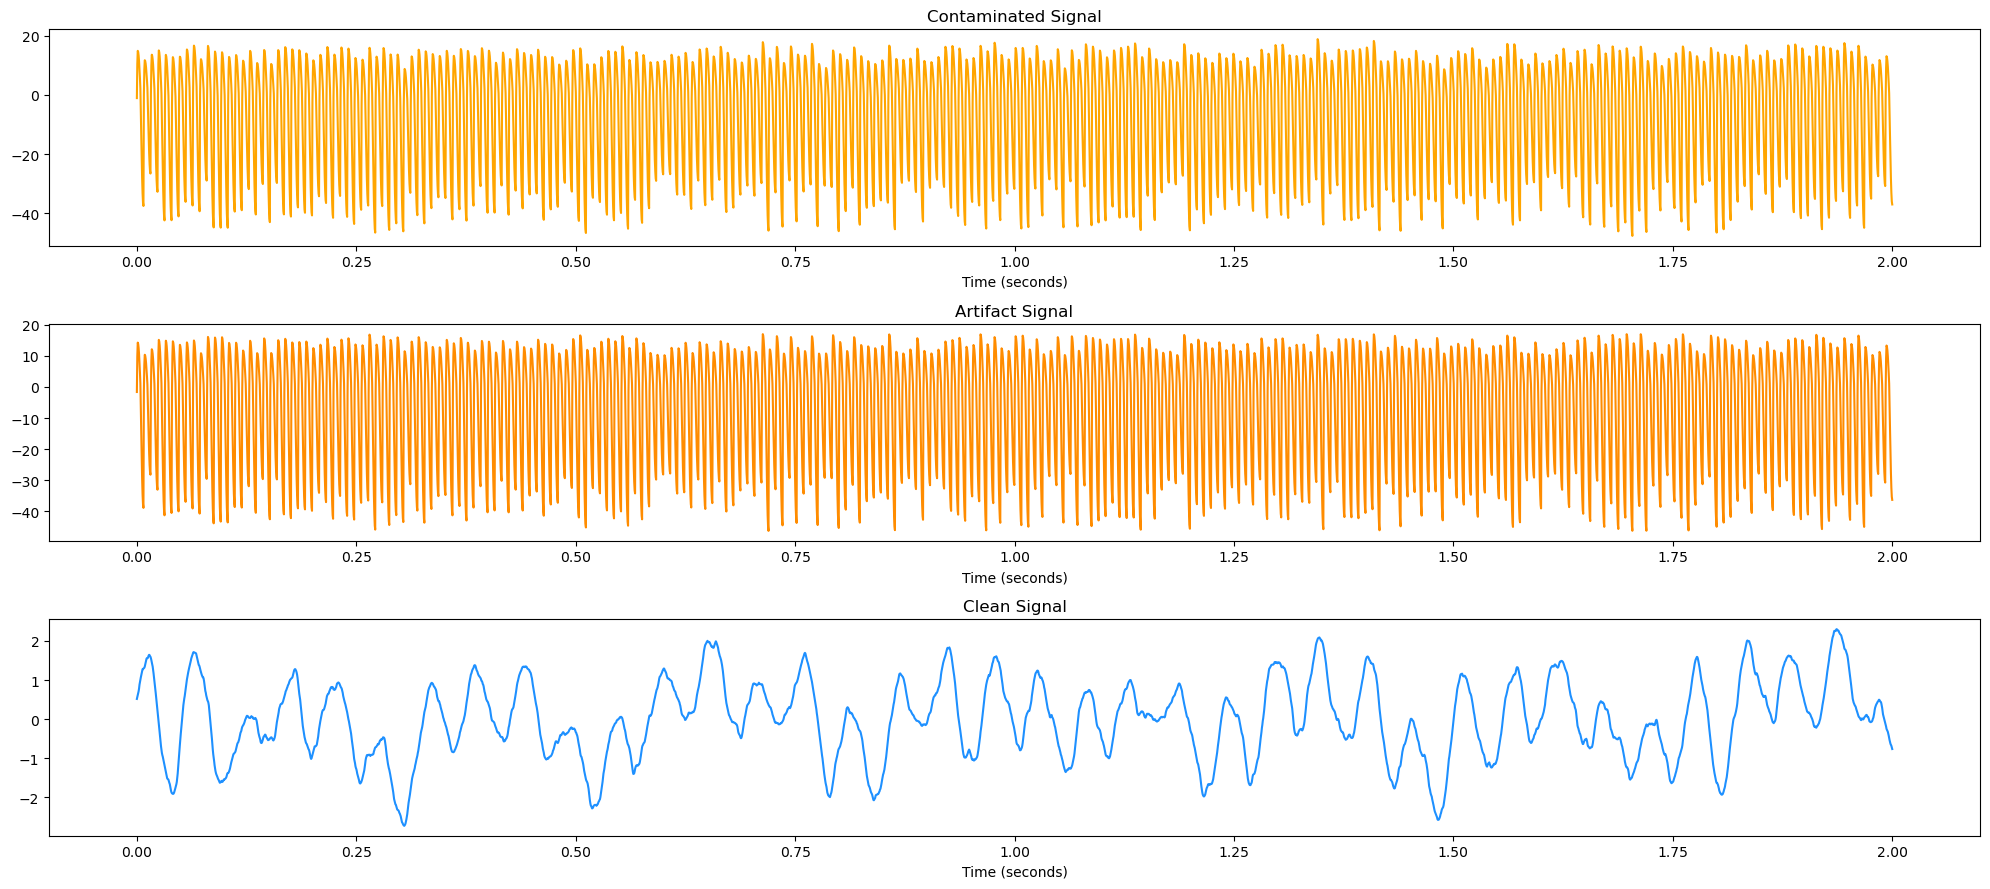

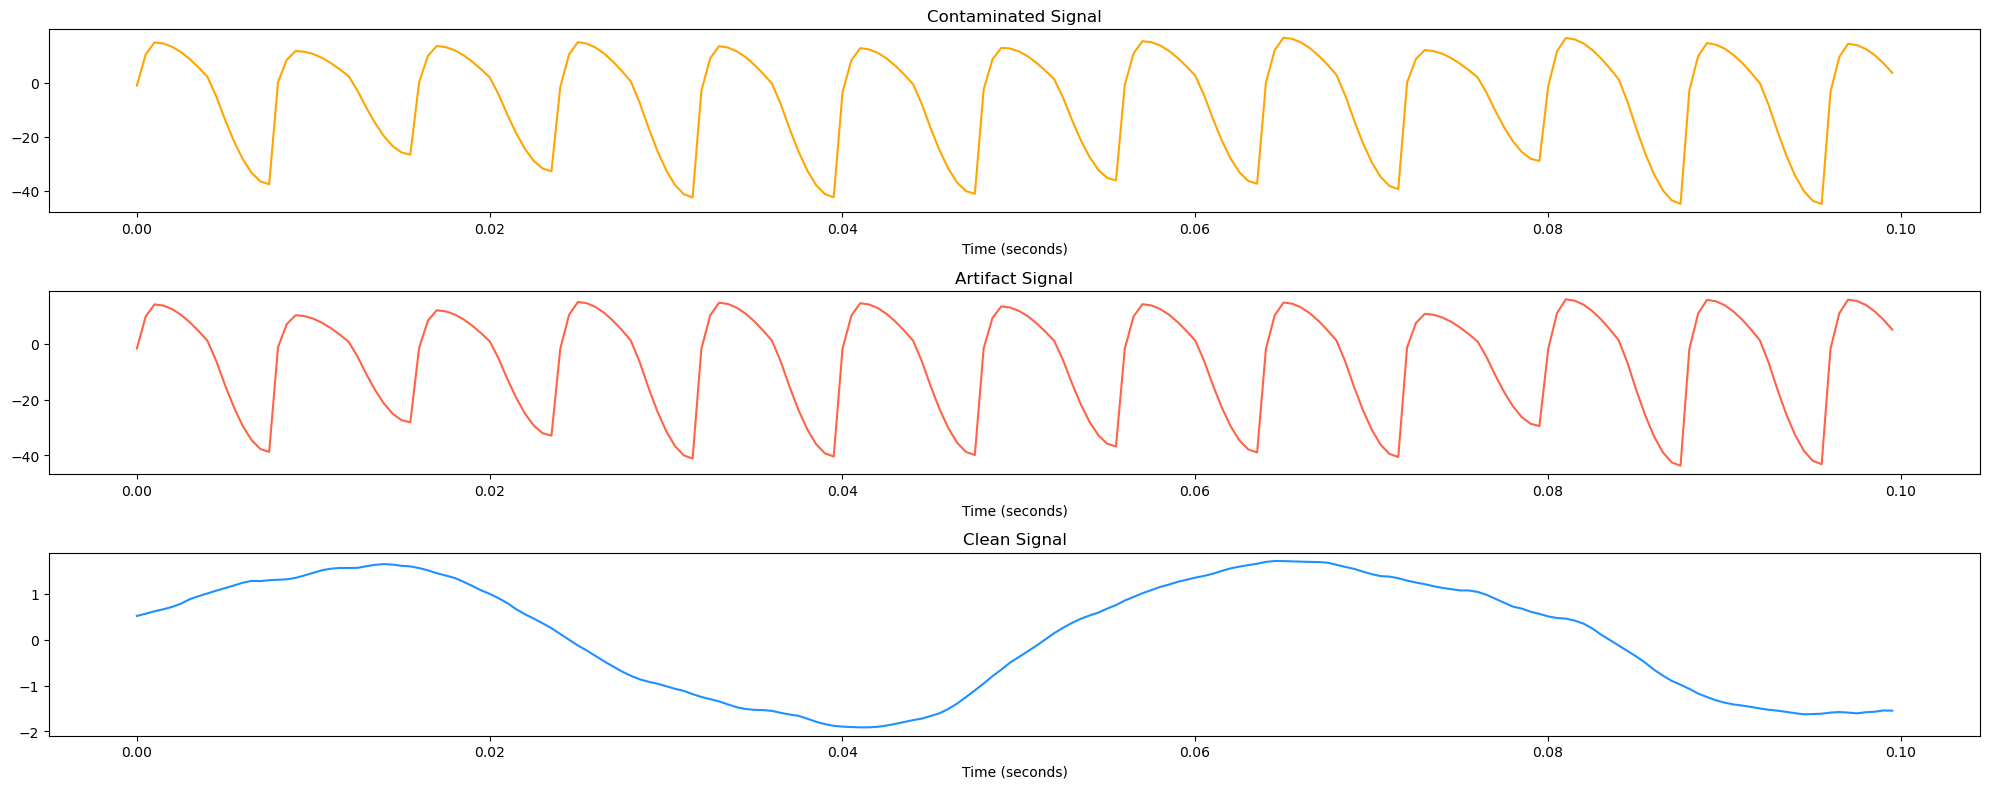

In [3]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

(1000, 2001)
(1000, 2001)
(2001,)


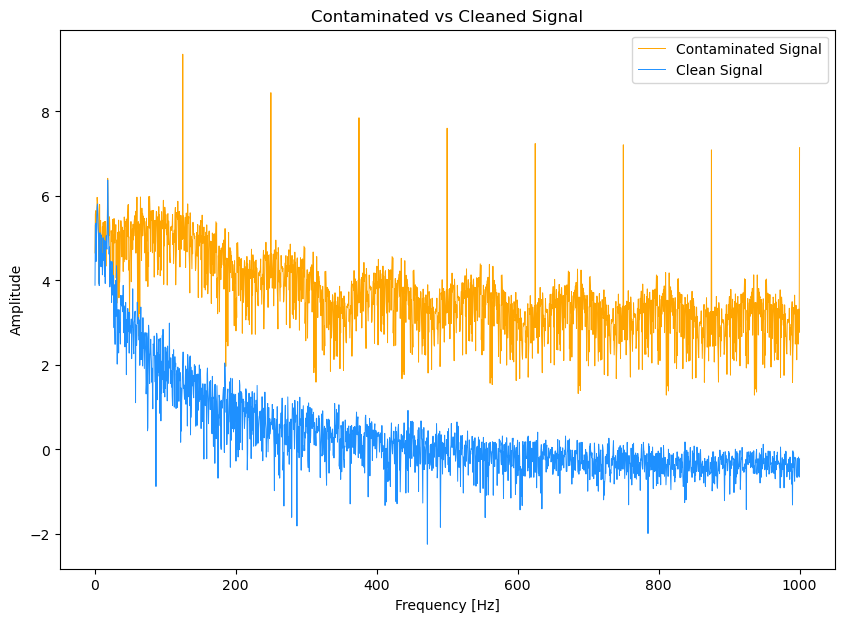

In [19]:
# power spectrum으로 변환
n = len(Contaminated_data[0])

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(Contaminated_data, axis=1)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(Clean_data, axis=1)
power_clean = np.abs(fft_clean)**2

print(power_contaminated.shape)
print(power_clean.shape)
print(freqs.shape)

plt.figure(figsize=(10, 7))
plt.plot(freqs[1:], np.log10(power_contaminated[0][1:]), label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], np.log10(power_clean[0][1:]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude');plt.title('Contaminated vs Cleaned Signal');plt.legend();plt.show()

In [23]:
# Time domain Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = []

scaler_x.fit(Contaminated_data[0].reshape(-1, 1))
scaler_y.fit(Clean_data[0].reshape(-1, 1))

for xx, yy in zip(Contaminated_data, Clean_data):
    scaled_x = scaler_x.transform(xx.reshape(-1, 1))
    scaled_y = scaler_y.transform(yy.reshape(-1, 1))
    X.append(scaled_x.squeeze())
    y.append(scaled_y.squeeze())

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 4000)
y: (1000, 4000)


In [24]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [25]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class simpleLSTM1d(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x).squeeze(-1) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [26]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = simpleLSTM1d(input_size, hidden_size, output_size, num_layers).to(device)
print(model)

simpleLSTM1d(
  (dropout): Dropout(p=0.1, inplace=False)
  (gelu): GELU(approximate='none')
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [27]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_welch, y_welch):
        signal_loss = self.mse_loss(y_pred, y)
        welch_loss = self.mse_loss(y_pred_welch, y_welch)
        return self.alpha * signal_loss + (1 - self.alpha) * welch_loss

In [28]:
# 손실 함수와 옵티마이저 정의
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 200
fs = 2000

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.shape
        y = y.view(batch_size, -1)
        y_pred = y_pred.view(batch_size, -1)

        # 텐서를 CPU로 옮기고 NumPy 배열로 변환
        y_cpu = y.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()

        
        # Welch 스펙트럼 계산
        y_welch_list = [welch(y_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]
        y_pred_welch_list = [welch(y_pred_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]

        # Welch 결과의 길이를 모델의 입력 형태와 맞추기
        # 여기에 적절한 패딩이나 크기 조정이 필요할 수 있습니다
        y_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_welch_list])
        y_pred_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_pred_welch_list])

        # NumPy 배열을 다시 텐서로 변환하여 손실 함수에 전달
        y_welch = torch.tensor(y_welch, dtype=torch.float32).to(device)
        y_pred_welch = torch.tensor(y_pred_welch, dtype=torch.float32).to(device)

        loss = criterion(y_pred, y, y_pred_welch, y_welch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1)%1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.4077852666378021
Epoch 10/200, Loss: 0.2626839578151703
Epoch 15/200, Loss: 0.2599884867668152
Epoch 20/200, Loss: 0.23340651392936707
Epoch 25/200, Loss: 0.22230245172977448
Epoch 30/200, Loss: 0.22935818135738373
Epoch 35/200, Loss: 0.2203228771686554
Epoch 40/200, Loss: 0.2130698412656784
Epoch 45/200, Loss: 0.21274539828300476
Epoch 50/200, Loss: 0.21151778101921082
Epoch 55/200, Loss: 0.2082057148218155
Epoch 60/200, Loss: 0.20784667134284973
Epoch 65/200, Loss: 0.2155776172876358
Epoch 70/200, Loss: 0.20564037561416626
Epoch 75/200, Loss: 0.20174919068813324
Epoch 80/200, Loss: 0.20223410427570343
Epoch 85/200, Loss: 0.20287171006202698
Epoch 90/200, Loss: 0.2022780328989029
Epoch 95/200, Loss: 0.1999477595090866
Epoch 100/200, Loss: 0.2330983281135559
Epoch 105/200, Loss: 0.1993933469057083
Epoch 110/200, Loss: 0.2061234712600708
Epoch 115/200, Loss: 0.19543124735355377
Epoch 120/200, Loss: 0.1966976523399353
Epoch 125/200, Loss: 0.1987127661705017
Epoch 130

In [34]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.shape
        y = y.view(batch_size, -1).cpu()
        y_pred = y_pred.view(batch_size, -1).cpu()
        print("y.shape:", y.shape)

        _, y_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        _, y_pred_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        print("y_welch.shape:", y_welch.shape)

        loss = criterion(y_pred, y, y_pred_welch, y_welch)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_welch.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_welch.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Test Loss: {val_loss.item()}')           

y.shape: torch.Size([32, 4000])
y_welch.shape: (32, 129)


TypeError: 'int' object is not callable

Mean Absolute Error: 0.005331624764949083
Mean Squared Error: 4.850283221458085e-05


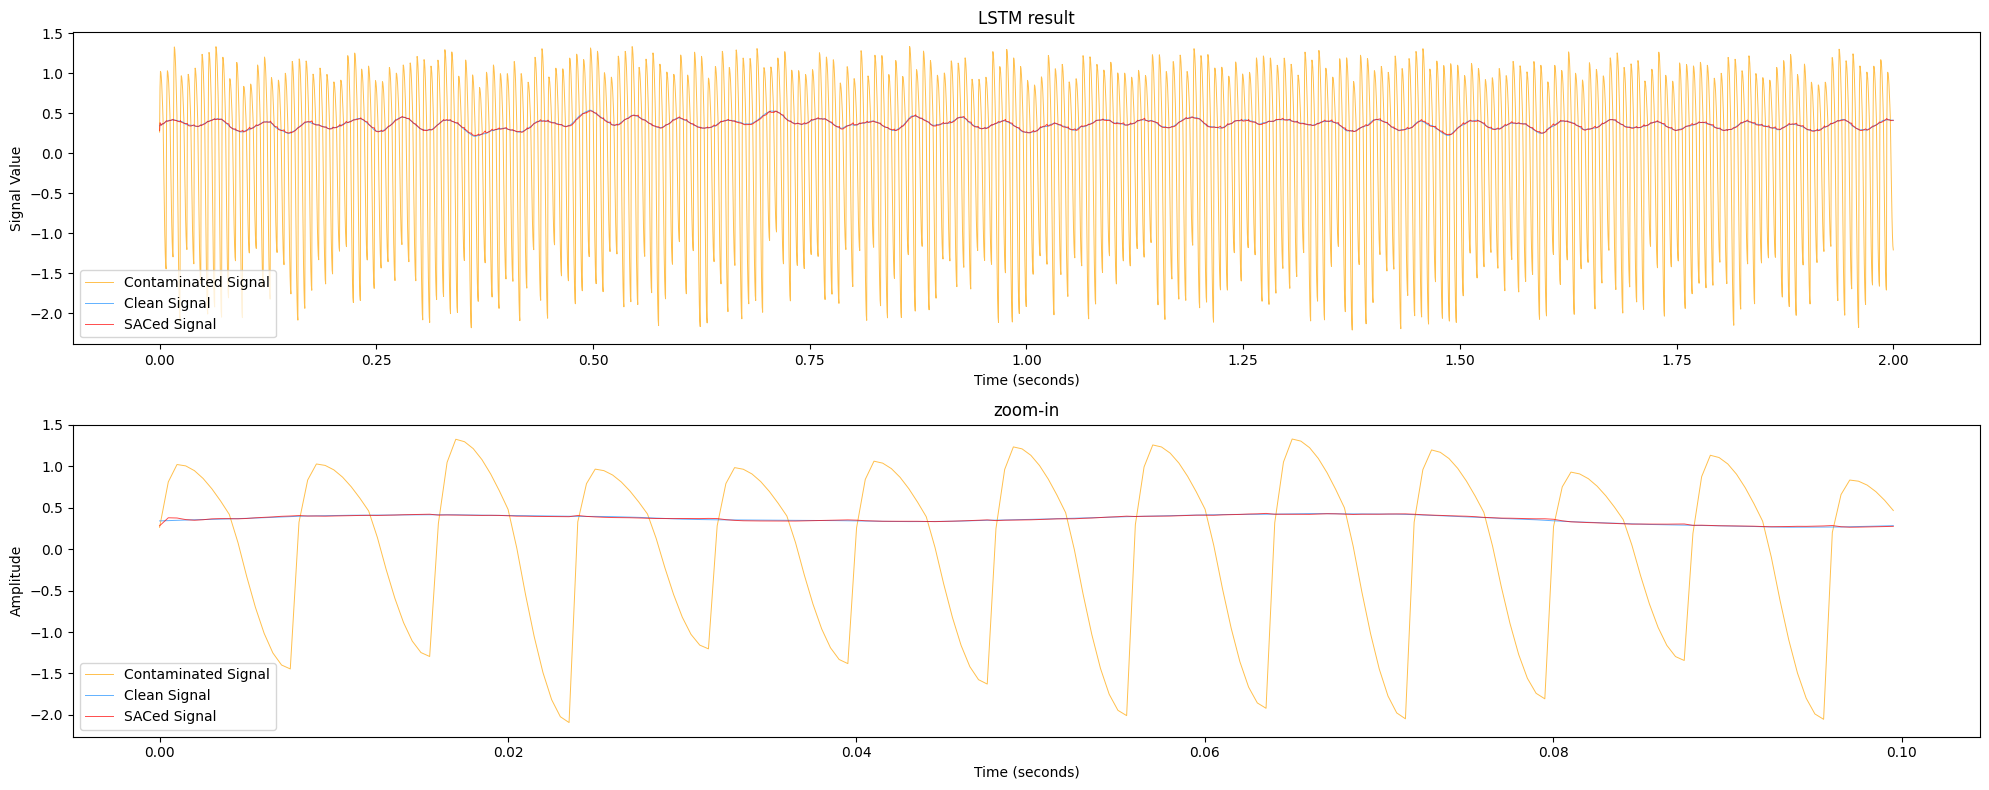

In [ ]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

# time signal의 scale을 [0, 100]으로 통일
scaler = MinMaxScaler(feature_range=(0, 100))
scaler.fit(Clean_signal.reshape(-1, 1))

scaled_SACed_signal = scaler.transform(SACed_signal.reshape(-1, 1))
scaled_Clean_signal = scaler.transform(Clean_signal.reshape(-1, 1))
scaled_Contaminated_signal = scaler.transform(Contaminated_signal.reshape(-1, 1))

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
# plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('LSTM result')
plt.legend()

plt.subplot(2, 1, 2)
# plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('LSTM result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

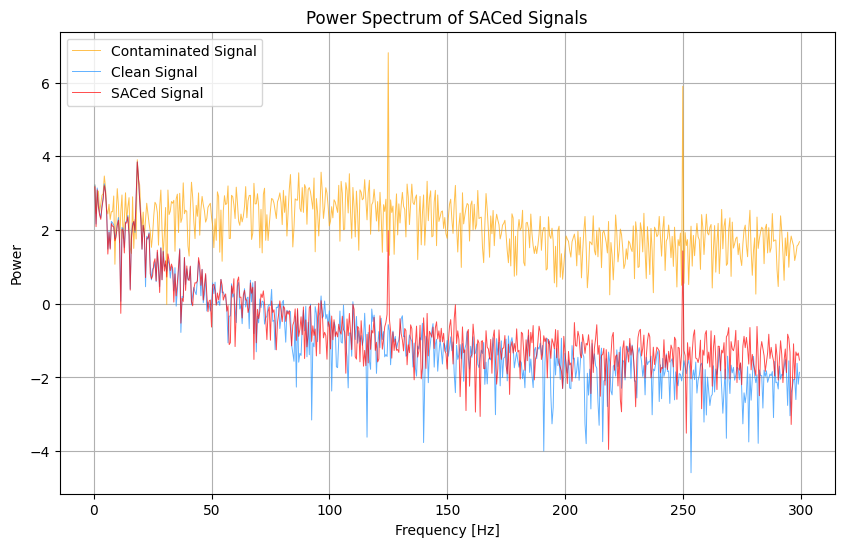

Mean Absolute Error: 0.884984590710376
Mean Squared Error: 1.1324851931030844


In [ ]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(Contaminated_signal)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(Clean_signal)
power_clean = np.abs(fft_clean)**2

fft_SACed = np.fft.rfft(SACed_signal)
power_SACed = np.abs(fft_SACed)**2

plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_contaminated)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_clean)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_SACed)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of SACed Signals')
plt.xlabel('Frequency [Hz]');plt.ylabel('Power');plt.legend();plt.grid(True);plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_SACed), np.log10(power_clean))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_SACed), np.log10(power_clean))}")